Kaggle: https://www.kaggle.com/c/DontGetKicked

One of the biggest challenges of an auto dealership purchasing a used car at an auto auction is the risk of that the vehicle might have serious issues that prevent it from being sold to customers. The auto community calls these unfortunate purchases "kicks".

Kicked cars often result when there are tampered odometers, mechanical issues the dealer is not able to address, issues with getting the vehicle title from the seller, or some other unforeseen problem. Kick cars can be very costly to dealers after transportation cost, throw-away repair work, and market losses in reselling the vehicle.

Modelers who can figure out which cars have a higher risk of being kick can provide real value to dealerships trying to provide the best inventory selection possible to their customers.

The challenge of this competition is to predict if the car purchased at the Auction is a Kick (bad buy).

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.cross_validation import train_test_split
from sklearn import metrics, cross_validation
from sklearn.linear_model import LogisticRegression as logreg 
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

/Users/Ke/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read in the data 
# the data format is "dataframe"
data = pd.read_csv("training.csv")
#data.head()
len(data.index) # number of data (cars)

72983

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
RefId                                72983 non-null int64
IsBadBuy                             72983 non-null int64
PurchDate                            72983 non-null object
Auction                              72983 non-null object
VehYear                              72983 non-null int64
VehicleAge                           72983 non-null int64
Make                                 72983 non-null object
Model                                72983 non-null object
Trim                                 70623 non-null object
SubModel                             72975 non-null object
Color                                72975 non-null object
Transmission                         72974 non-null object
WheelTypeID                          69814 non-null float64
WheelType                            69809 non-null object
VehOdo                               72983 non-null int64
Nationalit

In [4]:
# drop records with NAs for selected features and some inrelevant features 
data2 = data.dropna(axis =0, how = 'any', subset = ['Color','Transmission','Nationality','Size','TopThreeAmericanName','MMRAcquisitionAuctionAveragePrice','MMRAcquisitionAuctionCleanPrice','MMRAcquisitionRetailAveragePrice',     
'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
'MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice'])
len(data2.index)

72658

In [5]:
# data visualization 
# The purpose here is to check the variances of the features with categorical values, so that categories 
# with small counts can be grouped together
%matplotlib inline

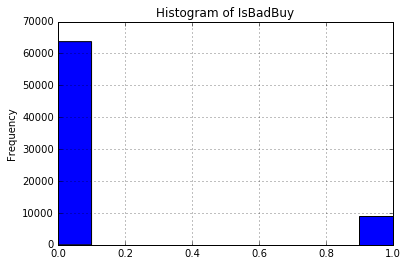

In [6]:
# check the response distribution
# histogram of isBadBuy
data2.IsBadBuy.hist()
plt.title('Histogram of IsBadBuy')
plt.xlabel('')
plt.ylabel('Frequency')

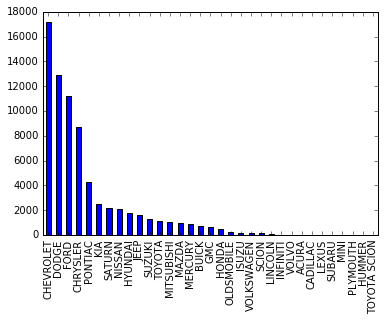

In [7]:
data2.Make.value_counts().plot(kind='bar')

In [8]:
def recategorize(data,columnname):
    # only when a feature shared by more than 5% of the totally record, we will retain it
    counts = data[columnname].value_counts()
    nameSet = set(counts[counts>= 0.01*len(data.index)].index.values)
    # at least 5% of all the data
    data.loc[:,columnname] = data[columnname].apply(lambda x:'OTHER'if x not in nameSet else x)
    return data

/Users/Ke/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


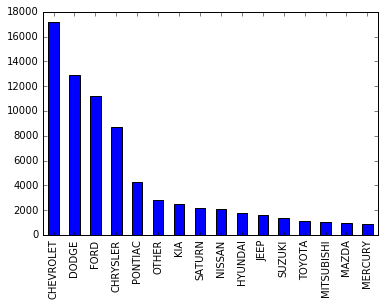

In [9]:
data2 = recategorize(data2, 'Make')
data2.Make.value_counts().plot(kind='bar')

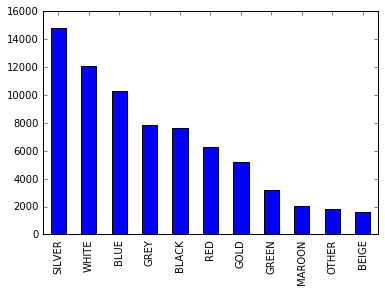

In [10]:
data2 = recategorize(data2, 'Color')
data2.Color.value_counts().plot(kind='bar')

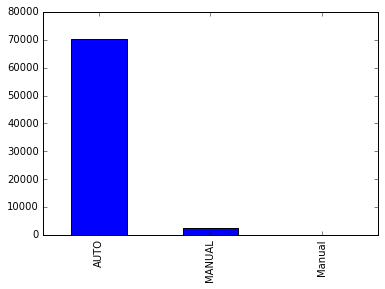

In [11]:
data.Transmission.value_counts().plot(kind='bar')

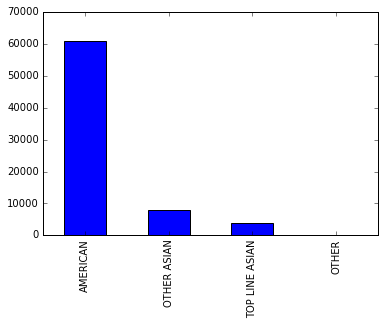

In [12]:
data.Nationality.value_counts().plot(kind='bar')

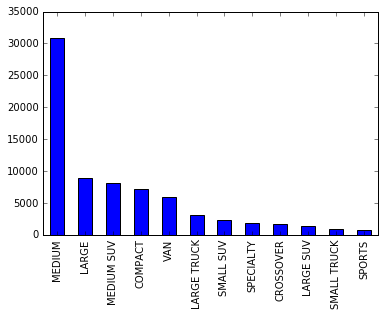

In [13]:
data.Size.value_counts().plot(kind='bar')

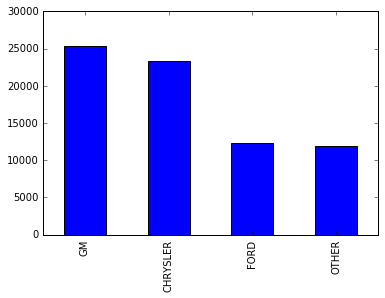

In [14]:
data.TopThreeAmericanName .value_counts().plot(kind='bar')

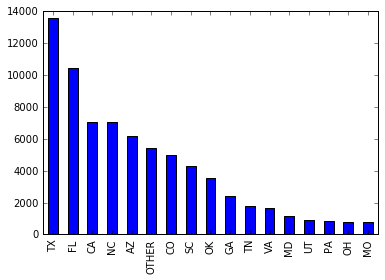

In [15]:
data2 = recategorize(data2, 'VNST')
data2.VNST.value_counts().plot(kind='bar')

In [16]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72658 entries, 0 to 72982
Data columns (total 34 columns):
RefId                                72658 non-null int64
IsBadBuy                             72658 non-null int64
PurchDate                            72658 non-null object
Auction                              72658 non-null object
VehYear                              72658 non-null int64
VehicleAge                           72658 non-null int64
Make                                 72658 non-null object
Model                                72658 non-null object
Trim                                 70301 non-null object
SubModel                             72658 non-null object
Color                                72658 non-null object
Transmission                         72658 non-null object
WheelTypeID                          69499 non-null float64
WheelType                            69494 non-null object
VehOdo                               72658 non-null int64
Nationalit

In [17]:
data2_cleaned = data2.drop(["RefId", "PurchDate","VehYear", "WheelTypeID","BYRNO","VNZIP1","PRIMEUNIT","AUCGUART"],axis=1)
data2_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72658 entries, 0 to 72982
Data columns (total 26 columns):
IsBadBuy                             72658 non-null int64
Auction                              72658 non-null object
VehicleAge                           72658 non-null int64
Make                                 72658 non-null object
Model                                72658 non-null object
Trim                                 70301 non-null object
SubModel                             72658 non-null object
Color                                72658 non-null object
Transmission                         72658 non-null object
WheelType                            69494 non-null object
VehOdo                               72658 non-null int64
Nationality                          72658 non-null object
Size                                 72658 non-null object
TopThreeAmericanName                 72658 non-null object
MMRAcquisitionAuctionAveragePrice    72658 non-null float64
MMRAcqui

In [18]:
# generate dummy variables for categorical data 
dataFinal = pd.get_dummies(data2_cleaned)
len(list(dataFinal))

2141

In [19]:
dataFinal.head()

,IsBadBuy,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,...,VNST_NC,VNST_OH,VNST_OK,VNST_OTHER,VNST_PA,VNST_SC,VNST_TN,VNST_TX,VNST_UT,VNST_VA
0,0,3,89046,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,5,93593,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,4,73807,3202.0,4760.0,6943.0,8457.0,4035.0,5557.0,7146.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,5,65617,1893.0,2675.0,4658.0,5690.0,1844.0,2646.0,4375.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,69367,3913.0,5054.0,7723.0,8707.0,3247.0,4384.0,6739.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
Y = dataFinal.loc[:,"IsBadBuy"]
X = dataFinal.drop("IsBadBuy",1)

In [21]:
X.head()

,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,...,VNST_NC,VNST_OH,VNST_OK,VNST_OTHER,VNST_PA,VNST_SC,VNST_TN,VNST_TX,VNST_UT,VNST_VA
0,3,89046,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,12409.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,93593,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,12791.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,73807,3202.0,4760.0,6943.0,8457.0,4035.0,5557.0,7146.0,8702.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,65617,1893.0,2675.0,4658.0,5690.0,1844.0,2646.0,4375.0,5518.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,69367,3913.0,5054.0,7723.0,8707.0,3247.0,4384.0,6739.0,7911.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
from sklearn.preprocessing import StandardScaler as SC
sc = SC()
Xnew = sc.fit_transform(X)

In [24]:
Xnew[:5]

array([[-0.6899679 ,  1.20269835,  0.82282644, ..., -0.47870472,
        -0.11040614, -0.15253078],
       [ 0.47933884,  1.51482274,  0.29448878, ..., -0.47870472,
        -0.11040614, -0.15253078],
       [-0.10531453,  0.15663199, -1.18859282, ..., -0.47870472,
        -0.11040614, -0.15253078],
       [ 0.47933884, -0.4055626 , -1.72017929, ..., -0.47870472,
        -0.11040614, -0.15253078],
       [-0.10531453, -0.14814749, -0.89985486, ..., -0.47870472,
        -0.11040614, -0.15253078]])